In [1]:
import numpy as np

import cv2
from skimage import io

import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
import scipy.io as scio
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM

import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

import os
from importlib import reload

import sys
sys.path.append('/Users/simonfreedman/cqub/bifurc/paper_figs')
import myfun as mf

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches


import time
import re
import glob
import pickle as pkl
from scipy.spatial import Delaunay
import networkx as nx

import mat73

In [2]:
add1 = np.array([[1,0],[0,1],[-1,0],[0,-1]])
add2 = 2*add1

def edge_pix(pix):
    
    # returns the pixels from pix that are on the edge
    # assumes cell is filled in
    
    pix_plus_one  = pix[:,np.newaxis] + add1[np.newaxis]
    pix_set       = set([tuple(x) for x in pix]) 
    pix_plus1_set = set([tuple(x) for x in pix_plus_one.reshape((-1,2))])
    outer_pix     = np.array(list(pix_plus1_set - pix_set)) # these are the pixels immediately outside the cell
    outer_m1      = outer_pix[:,np.newaxis] + add1[np.newaxis] # shift back to within the cell
    outer_m1_set  = set([tuple(x) for x in outer_m1.reshape((-1,2))])
    return np.array(list(outer_m1_set & pix_set)) # intersect with the celladd2            = np.array([[2,0],[0,2],[-2,0],[0,-2]])

# source: https://stackoverflow.com/questions/12374781/how-to-find-all-neighbors-of-a-given-point-in-a-delaunay-triangulation-using-sci
def vertex_neighbors(vertex_id,tri):
    #use a less awful function name
    pointers = tri.vertex_neighbor_vertices[0]
    indices  = tri.vertex_neighbor_vertices[1]
    return indices[pointers[vertex_id]:pointers[vertex_id+1]]

def cells_touching(edge_pix1, pix2):
    
    # returns true if two cells share an edge, false otherwise
    
    edge_plus_two = edge_pix1[:,np.newaxis,:]+add2[np.newaxis,:,:]
    plus_two_set  = set([tuple(x) for x in edge_plus_two.reshape((-1,2))])
    pix2_set      = set([tuple(x) for x in pix2])
    return True if len(plus_two_set & pix2_set) > 0 else False

def border_pix(cell_edge_pix, bound_pixel_set):
    
    edge_plus_two = cell_edge_pix[:,np.newaxis,:]+add2[np.newaxis,:,:]
    plus_two_set  = set([tuple(x) for x in edge_plus_two.reshape((-1,2))])
    
    return np.array(list(plus_two_set & bound_pixel_set),dtype='int')

def get_border_cells(edge_pixels, bound_pixels):
    
    bound_pixel_set = set([tuple(x) for x in bound_pixels])   
    cell_border_pix = [border_pix(edge_pixels[i],bound_pixel_set) if len(edge_pixels[i])>0 else np.array([]) 
                       for i in range(len(edge_pixels))]
    
    return np.where(np.array(list(map(len,cell_border_pix)))>0)[0]

In [149]:
headdir = '/Users/simonfreedman/'
datdir  = '{0}/data/droso'.format(headdir)
matdir  = '{0}/mats'.format(datdir)
plotdir = '{0}/cqub/droso/plots'.format(headdir)
nm      = 'wildtype3'
fnm     = '{0}/{1}.mat'.format(matdir,nm)

outdir  = '{0}/ommatidia_data/{1}/obs'.format(datdir,nm)

In [150]:
if 'wildtype2' in nm or 'wildtype1' in nm:
    dat1 = mat73.loadmat(fnm)
else:
    dat1 = scio.loadmat(fnm)

In [151]:
#dat1['furrow_coordinate'].shape

In [152]:
dat_res  = [51.72 / 1024, 50.71 / 634, 50.71 / 634, 61.6 / 704, 61.6 / 704]  # microns/ pixel
pr_names = ['R8','R2','R5','R3','R4']

precluster idxs stay constant across time
but they aren't all tracked at every time
so how do we deal with that
at each time i need the pixels that are in that cell
and i need the centroid of that cell
so i need a list of dicts
index of the list is the time 
other problems
indexes start at 1 and not at 0
1 in matlab (0 in python) gives me the boundary pixels
so first "cell" is really the index 2

simplest: 
    
    pixels: a list of length sum(ncells(t), t=0, t=nt) of [Mx2] numpy arrays which has all the pixels of every cell at every time in the movie

some arrays of size nt, ncell:
    
    (1) the indices of the cell in the list. if the cell i is not annotated at time t then should be -1
    (2) the photoreceptor it belongs to, or -1
    (3) 1 if it is in the morophogenetic furrow, 0 otherwise (to be created later)
    (4) the track it is part of, -1 otherwise
    
    which is the indices of that cell in that list
    a second array 


In [153]:
ntrack, nt         = dat1['tracks'].shape

boundary_pixels    = []
cell_pixels        = []
cell_hull_pix_idxs = []
cell_edge_pix      = []
cell_pixel_idx     = np.zeros((nt, ntrack), dtype='int') - 1
npix               = np.zeros((nt, ntrack))
cell_ctr           = np.zeros((nt, ntrack, 2)) - np.nan


k            = 0
tracks       = np.array(dat1['tracks'],dtype=int) - 1 # matlab --> python indexing

for t in np.arange(nt):
    
    if t%10 == 0:
        print('t={0}'.format(t))
        
    for i in range(ntrack):
        cell_id = tracks[i,t] 
        if cell_id >= 0: # don't care about the boundary
            pix = np.array(dat1['cell_area'][t][0][cell_id][0], dtype=int) - 1
            if cell_id == 0:
                boundary_pixels.append(pix)
            else:
                cell_pixels.append(pix)
                cell_hull_pix_idxs.append(ConvexHull(pix).vertices)
                cell_edge_pix.append(edge_pix(pix))
                cell_pixel_idx[t, i] = k
                cell_ctr[t, i]       = np.mean(pix, axis=0)
                npix[t, i]           = len(pix)
                k += 1

t=0
t=10
t=20
t=30
t=40
t=50
t=60
t=70
t=80
t=90


In [154]:
if 'scabrous' in nm or 'wildtype3' in nm:
    # works for scabrous mutants....
    precl_idxs = np.array([x[:,0] for x in dat1['preclusters'][0]], dtype='int')-1
else:
# works for datasets 1 and 2
    precl_idxs = np.array(dat1['preclusters'], dtype='int') - 1

photo_idxs = precl_idxs.reshape(-1)

In [155]:
# find the border cells
bord_cell_idxs = []
for t in np.arange(nt):
    if t%5==0:
        print('t = {0}/{1}'.format(t,nt))
    edge_pixels_t = [cell_edge_pix[cell_pixel_idx[t,i]] if cell_pixel_idx[t,i]!=-1 else [] for i in range(ntrack)]
    bord_cell_idxs.append(get_border_cells(edge_pixels_t, boundary_pixels[t]))

t = 0/98
t = 5/98
t = 10/98
t = 15/98
t = 20/98
t = 25/98
t = 30/98
t = 35/98
t = 40/98
t = 45/98
t = 50/98
t = 55/98
t = 60/98
t = 65/98
t = 70/98
t = 75/98
t = 80/98
t = 85/98
t = 90/98
t = 95/98


In [156]:
# find the MF cells
threshs = {'wildtype1': [650, 10],
           'wildtype2': [300, 10],
           'wildtype3': [350, 10],
          'scabrous_strong': [300,50],
          'scabrous_weak'  : [350,50]}
thresh          = threshs[nm][0] # dataset1 used 650, dataset2 dataset 3 used 350
cc_thresh       = threshs[nm][1] # used 10 on datasets 1-3
mf_idxs_all     = []
small_cells_all = []
simps_all       = []
bound_verts_all = []

nrow, ncol, nfrm = dat1['raw_images'].shape

imgs = np.zeros((nt, nrow, ncol))
for t in np.arange(nt):
    if t%5==0:
        print('t = {0}/{1}'.format(t,nt))
    
    pidxs = cell_pixel_idx[t]

    
    # generate the triangulation using the cells that are actually tracked at time t
    cidxs    = np.where(npix[t]>0)[0]
    cctrs    = cell_ctr[t, cidxs]
    tri      = Delaunay(cctrs)

    small_cell_idxs   = np.where(npix[t, cidxs]<thresh)[0]
    small_cells_graph = nx.Graph()

    for i in small_cell_idxs:
        if cidxs[i] in bord_cell_idxs[t]: # don't use border cells to make edges, bc yields non-neighbor edges
            continue
        neighbors = np.intersect1d(vertex_neighbors(i,tri),small_cell_idxs)
        
        #if -1 not in neighbors: #another check that its not a border cell; probably unnecessary now
        for j in neighbors:
            if not small_cells_graph.has_edge(i,j):
                # additional check that the two cells are touching?
                # this is slow :(
                if cells_touching(cell_edge_pix[pidxs[cidxs[i]]], 
                                  cell_pixels[pidxs[cidxs[j]]]):
                    small_cells_graph.add_edge(i,j)
    
    ccs          = list(nx.connected_components(small_cells_graph))
    big_cc_cidxs = np.hstack([list(ccs[i]) for i in range(len(ccs)) if len(ccs[i])>cc_thresh])
    mf_idxs      = np.setdiff1d(cidxs[big_cc_cidxs], photo_idxs)
    
    # gmm filtering
    ctrs = cell_ctr[t,mf_idxs][:,[0]]
    gmms = [GMM(n_components=i).fit(ctrs) for i in [1,2]]
    bics = np.array([x.bic(ctrs) for x in gmms])
    
    if bics[0]>bics[1]*1.01:
        clust_labels = gmms[1].predict(ctrs)
        n1 = np.sum(clust_labels)
        n0 = clust_labels.shape[0]-n1
        longer_cluster_idx = int(n0<n1)
        mf_idxs = mf_idxs[clust_labels==longer_cluster_idx]
    
    # end of gmm filtering
    
    small_cells_all.append(cidxs[small_cell_idxs])
    mf_idxs_all.append(mf_idxs)
    
    for i in cidxs:
        imgs[t, cell_pixels[pidxs[i]][:,0], cell_pixels[pidxs[i]][:,1]]=1
    for i in cidxs[small_cell_idxs]:
        imgs[t, cell_pixels[pidxs[i]][:,0], cell_pixels[pidxs[i]][:,1]]=2
    for i in np.intersect1d(photo_idxs, cidxs):
        imgs[t, cell_pixels[pidxs[i]][:,0], cell_pixels[pidxs[i]][:,1]]=3
    for i in mf_idxs:
        imgs[t, cell_pixels[pidxs[i]][:,0], cell_pixels[pidxs[i]][:,1]]=4


t = 0/98
t = 5/98
t = 10/98
t = 15/98
t = 20/98
t = 25/98
t = 30/98
t = 35/98
t = 40/98
t = 45/98
t = 50/98
t = 55/98
t = 60/98
t = 65/98
t = 70/98
t = 75/98
t = 80/98
t = 85/98
t = 90/98
t = 95/98


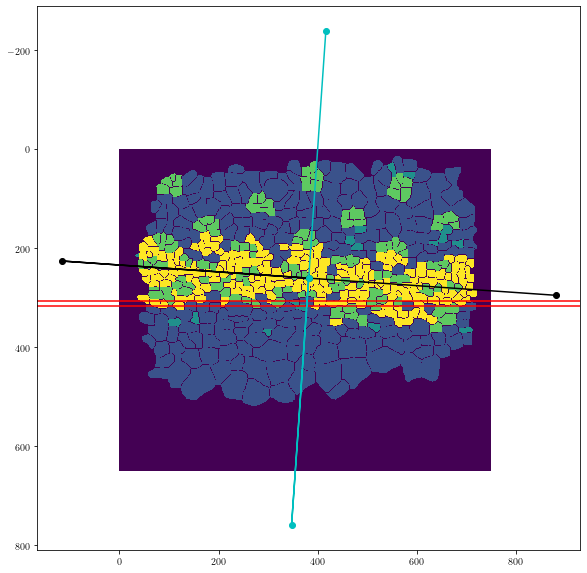

In [157]:
t = 0
mf_pix = np.vstack([cell_pixels[cell_pixel_idx[t, k]] for k in mf_idxs_all[t]])
fig,axs=plt.subplots(1,1,figsize=(10,10))
axs.imshow(imgs[t])
axs.axhline(np.mean(pix[:,0])-1*np.std(pix[:,0]), color='red')
axs.axhline(np.mean(pix[:,0])+1*np.std(pix[:,0]), color='red')

mf_pca = PCA().fit(mf_pix)
mf_mu = np.mean(mf_pix,axis=0)

pts0 = np.vstack([mf_mu,mf_mu+500*mf_pca.components_[0],mf_mu-500*mf_pca.components_[0]])
pts1 = np.vstack([mf_mu,mf_mu+500*mf_pca.components_[1],mf_mu-500*mf_pca.components_[1]])

axs.plot(pts0[:,1],pts0[:,0],'ko-')
axs.plot(pts1[:,1],pts1[:,0],'co-')

In [158]:
mf_pix = [np.vstack([cell_pixels[cell_pixel_idx[t, k]] for k in mf_idxs_all[t]]) for t in range(nt)]
mf_center = np.array([np.mean(mf_pix[t], axis=0) for t in range(nt)])
mf_axes = np.array([PCA().fit(p).components_ for p in mf_pix])

In [159]:
# # compute cell dists to MF
# mf_dist_par   = np.zeros((nt, ntrack)) - np.nan
# mf_dist_perp  = np.zeros((nt, ntrack)) - np.nan

# for t in np.arange(nt):
#     cidxs = np.where(npix[t]>0)[0]
    
#     col_mu    = np.mean(cell_ctr[t, cidxs],axis=0)[1] # (horizontal -- center of all cells, bc otherwise wonky)
#     row_mu    = np.mean(cell_ctr[t, mf_idxs_all[t]],axis=0)[0] # (vertical -- center of mf cells)
    
#     mf_mu     = np.array([row_mu, col_mu])
#     mf_dist_par[t,cidxs]  = (cell_ctr[t,cidxs] - mf_mu).dot(mf_axes[t,0])
#     mf_dist_perp[t,cidxs] = (cell_ctr[t,cidxs] - mf_mu).dot(mf_axes[t,1])

In [160]:
# compute cell dists to MF
nt = dat1['raw_images'].shape[-1] # only 117... vs should be 120
dist_mu   = np.zeros((nt, ntrack)) - np.nan
distx_mu  = np.zeros((nt, ntrack)) - np.nan
disty_mu  = np.zeros((nt, ntrack)) - np.nan
dist_std  = np.zeros((nt, ntrack)) - np.nan
distx_std = np.zeros((nt, ntrack)) - np.nan
disty_std = np.zeros((nt, ntrack)) - np.nan

mf_dist_par   = np.zeros((nt, ntrack)) - np.nan
mf_dist_perp  = np.zeros((nt, ntrack)) - np.nan

cell_ecad = np.zeros((nt, ntrack)) - np.nan
cell_dens = 1./npix #np.zeros((nt, ntrack)) - np.nan


for t in np.arange(nt):
    cidxs = np.where(npix[t]>0)[0]
    # define distances c - MF ...
    # so    patterned (high) cells should have negative x (row) distance
    # and unpatterned (low) cells should have positive x (row) distance
    dists              = cell_ctr[t,cidxs][:,np.newaxis] - cell_ctr[t,mf_idxs_all[t]][np.newaxis]
    norm_dists         = np.linalg.norm(dists, axis=2)
    dist_mu[t,cidxs]   = np.mean(norm_dists,axis=1)
    dist_std[t,cidxs]  = np.std(norm_dists,axis=1)
    
    distx_mu[t,cidxs]  = np.mean(dists[...,0],axis=1)
    distx_std[t,cidxs] = np.std(dists[...,0],axis=1)
    
    disty_mu[t,cidxs]  = np.mean(dists[...,1],axis=1)
    disty_std[t,cidxs] = np.std(dists[...,1],axis=1)
    
    for c in cidxs:
        cpix           = cell_pixels[cell_pixel_idx[t,c]]
        cell_ecad[t, c] = np.sum(dat1['raw_images'][cpix[:,0],cpix[:,1],t])
        
    # pca distance
    col_mu    = np.mean(cell_ctr[t, cidxs],axis=0)[1] # (horizontal -- center of all cells, bc otherwise wonky)
    row_mu    = np.mean(cell_ctr[t, mf_idxs_all[t]],axis=0)[0] # (vertical -- center of mf cells)
    
    mf_mu     = np.array([row_mu, col_mu])
    mf_dist_par[t,cidxs]  = (cell_ctr[t,cidxs] - mf_mu).dot(mf_axes[t,0])
    mf_dist_perp[t,cidxs] = (cell_ctr[t,cidxs] - mf_mu).dot(mf_axes[t,1])

aspect_ratios = np.array([np.divide(*PCA().fit(c).explained_variance_) for c in cell_pixels])

/Users/simonfreedman/opt/anaconda3/envs/img/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [161]:
# saving stuff

np.save('{0}/dist_par.npy'.format(outdir),  mf_dist_par)
np.save('{0}/dist_perp.npy'.format(outdir), mf_dist_perp)

np.save('{0}/xdist_mu.npy'.format(outdir), distx_mu)
np.save('{0}/ydist_mu.npy'.format(outdir), disty_mu)
np.save('{0}/xdist_std.npy'.format(outdir),distx_std)
np.save('{0}/ydist_std.npy'.format(outdir),disty_std)

np.save('{0}/npix.npy'.format(outdir), npix[0:nt])
np.save('{0}/ecad_tot.npy'.format(outdir), cell_ecad)

np.save('{0}/cell_ctr.npy'.format(outdir), cell_ctr)

f = open('{0}/mf_idxs.pkl'.format(outdir), 'wb')   # Pickle file is newly created where foo1.py is
pkl.dump(mf_idxs_all, f)          # dump data to f
f.close()

np.save('{0}/precluster_idxs.npy'.format(outdir), precl_idxs)
np.save('{0}/cell_pixel_idx.npy'.format(outdir), cell_pixel_idx)
np.save('{0}/cell_aspect_ratio.npy'.format(outdir), aspect_ratios[cell_pixel_idx])


f = open('{0}/cell_edge_pix.pkl'.format(outdir), 'wb')   # Pickle file is newly created where foo1.py is
pkl.dump(cell_edge_pix, f)          # dump data to f
f.close()

In [128]:
t=116
cidxs  = np.where(npix[t]>0)[0]
col_mu = np.mean(cell_ctr[t, cidxs],axis=0)[1]
row_mu = np.mean(cell_ctr[t, mf_idxs_all[t]],axis=0)[0]
#mf_mu
mf_mu  = np.array([row_mu, col_mu])
dist_par  = (cell_ctr[t,cidxs] - mf_mu).dot(mf_axes[t,0])
dist_perp = (cell_ctr[t,cidxs] - mf_mu).dot(mf_axes[t,1])
# mf_par  = mf_axes[t,0]-mf_center[t]+mf_mu # axes centered
# mf_perp = mf_axes[t,1]-mf_center[t]+mf_mu # axes centered
# mf_par  = mf_par / np.linalg.norm(mf_par)
# mf_perp = mf_perp / np.linalg.norm(mf_perp)
#mf_dists_par   = (cell_ctr[t,cidxs]-mf_mu).dot(mf_perp) / np.linalg.norm(mf_par)
#mf_dists_perp  = (cell_ctr[t,cidxs]-mf_mu).dot(mf_perp) / np.linalg.norm(mf_perp)



#col_mu = np.mean
#dists              = cell_ctr[t,cidxs][:,np.newaxis] - cell_ctr[t,mf_idxs_all[t]][np.newaxis]

(array([37., 39., 31., 33., 36., 26., 30., 35., 30., 26.]),
 array([-280.39532747, -220.89253457, -161.38974167, -101.88694877,
         -42.38415587,   17.11863703,   76.62142993,  136.12422283,
         195.62701573,  255.12980863,  314.63260153]),
 <a list of 10 Patch objects>)

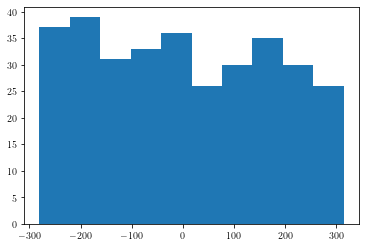

In [130]:
fig,axs=plt.subplots()
axs.hist(dist_par)

In [99]:
mf_axes[t,0].dot(mf_axes[t,1]), mf_par.dot(mf_perp)

(0.0, 0.9895536984522739)

In [112]:
trans_mat = np.array([mf_mu+np.array([1,0]), mf_mu+[0,1]]).T

In [119]:
mpar  = trans_mat.dot(mf_axes[t,0])
mperp = trans_mat.dot(mf_axes[t,1])

In [122]:
mpar - mf_mu, mperp-mf_mu

(array([ -770.17171254, -1321.58365396]),
 array([ -794.18099412, -1360.01545616]))

In [120]:
.dot(mperp)

602146.9266019058

In [117]:
trans_mat.dot(mf_axes[t,0]).dot(trans_mat.dot(mf_axes[t,1]))

602146.9266019058

In [ ]:
mmf_axs

In [50]:
col_mu = np.mean(cell_ctr[t, cidxs],axis=0)[1]
np.mean(cell_ctr[t, mf_idxs_all[t]],axis=0)

array([390.93008017, 680.26662323])

In [65]:
#len(mf_idxs_all[t]), len(cidxs)

In [66]:
#row_mu, col_mu

In [67]:
#cell_ctr[t,cidxs].shape

....................

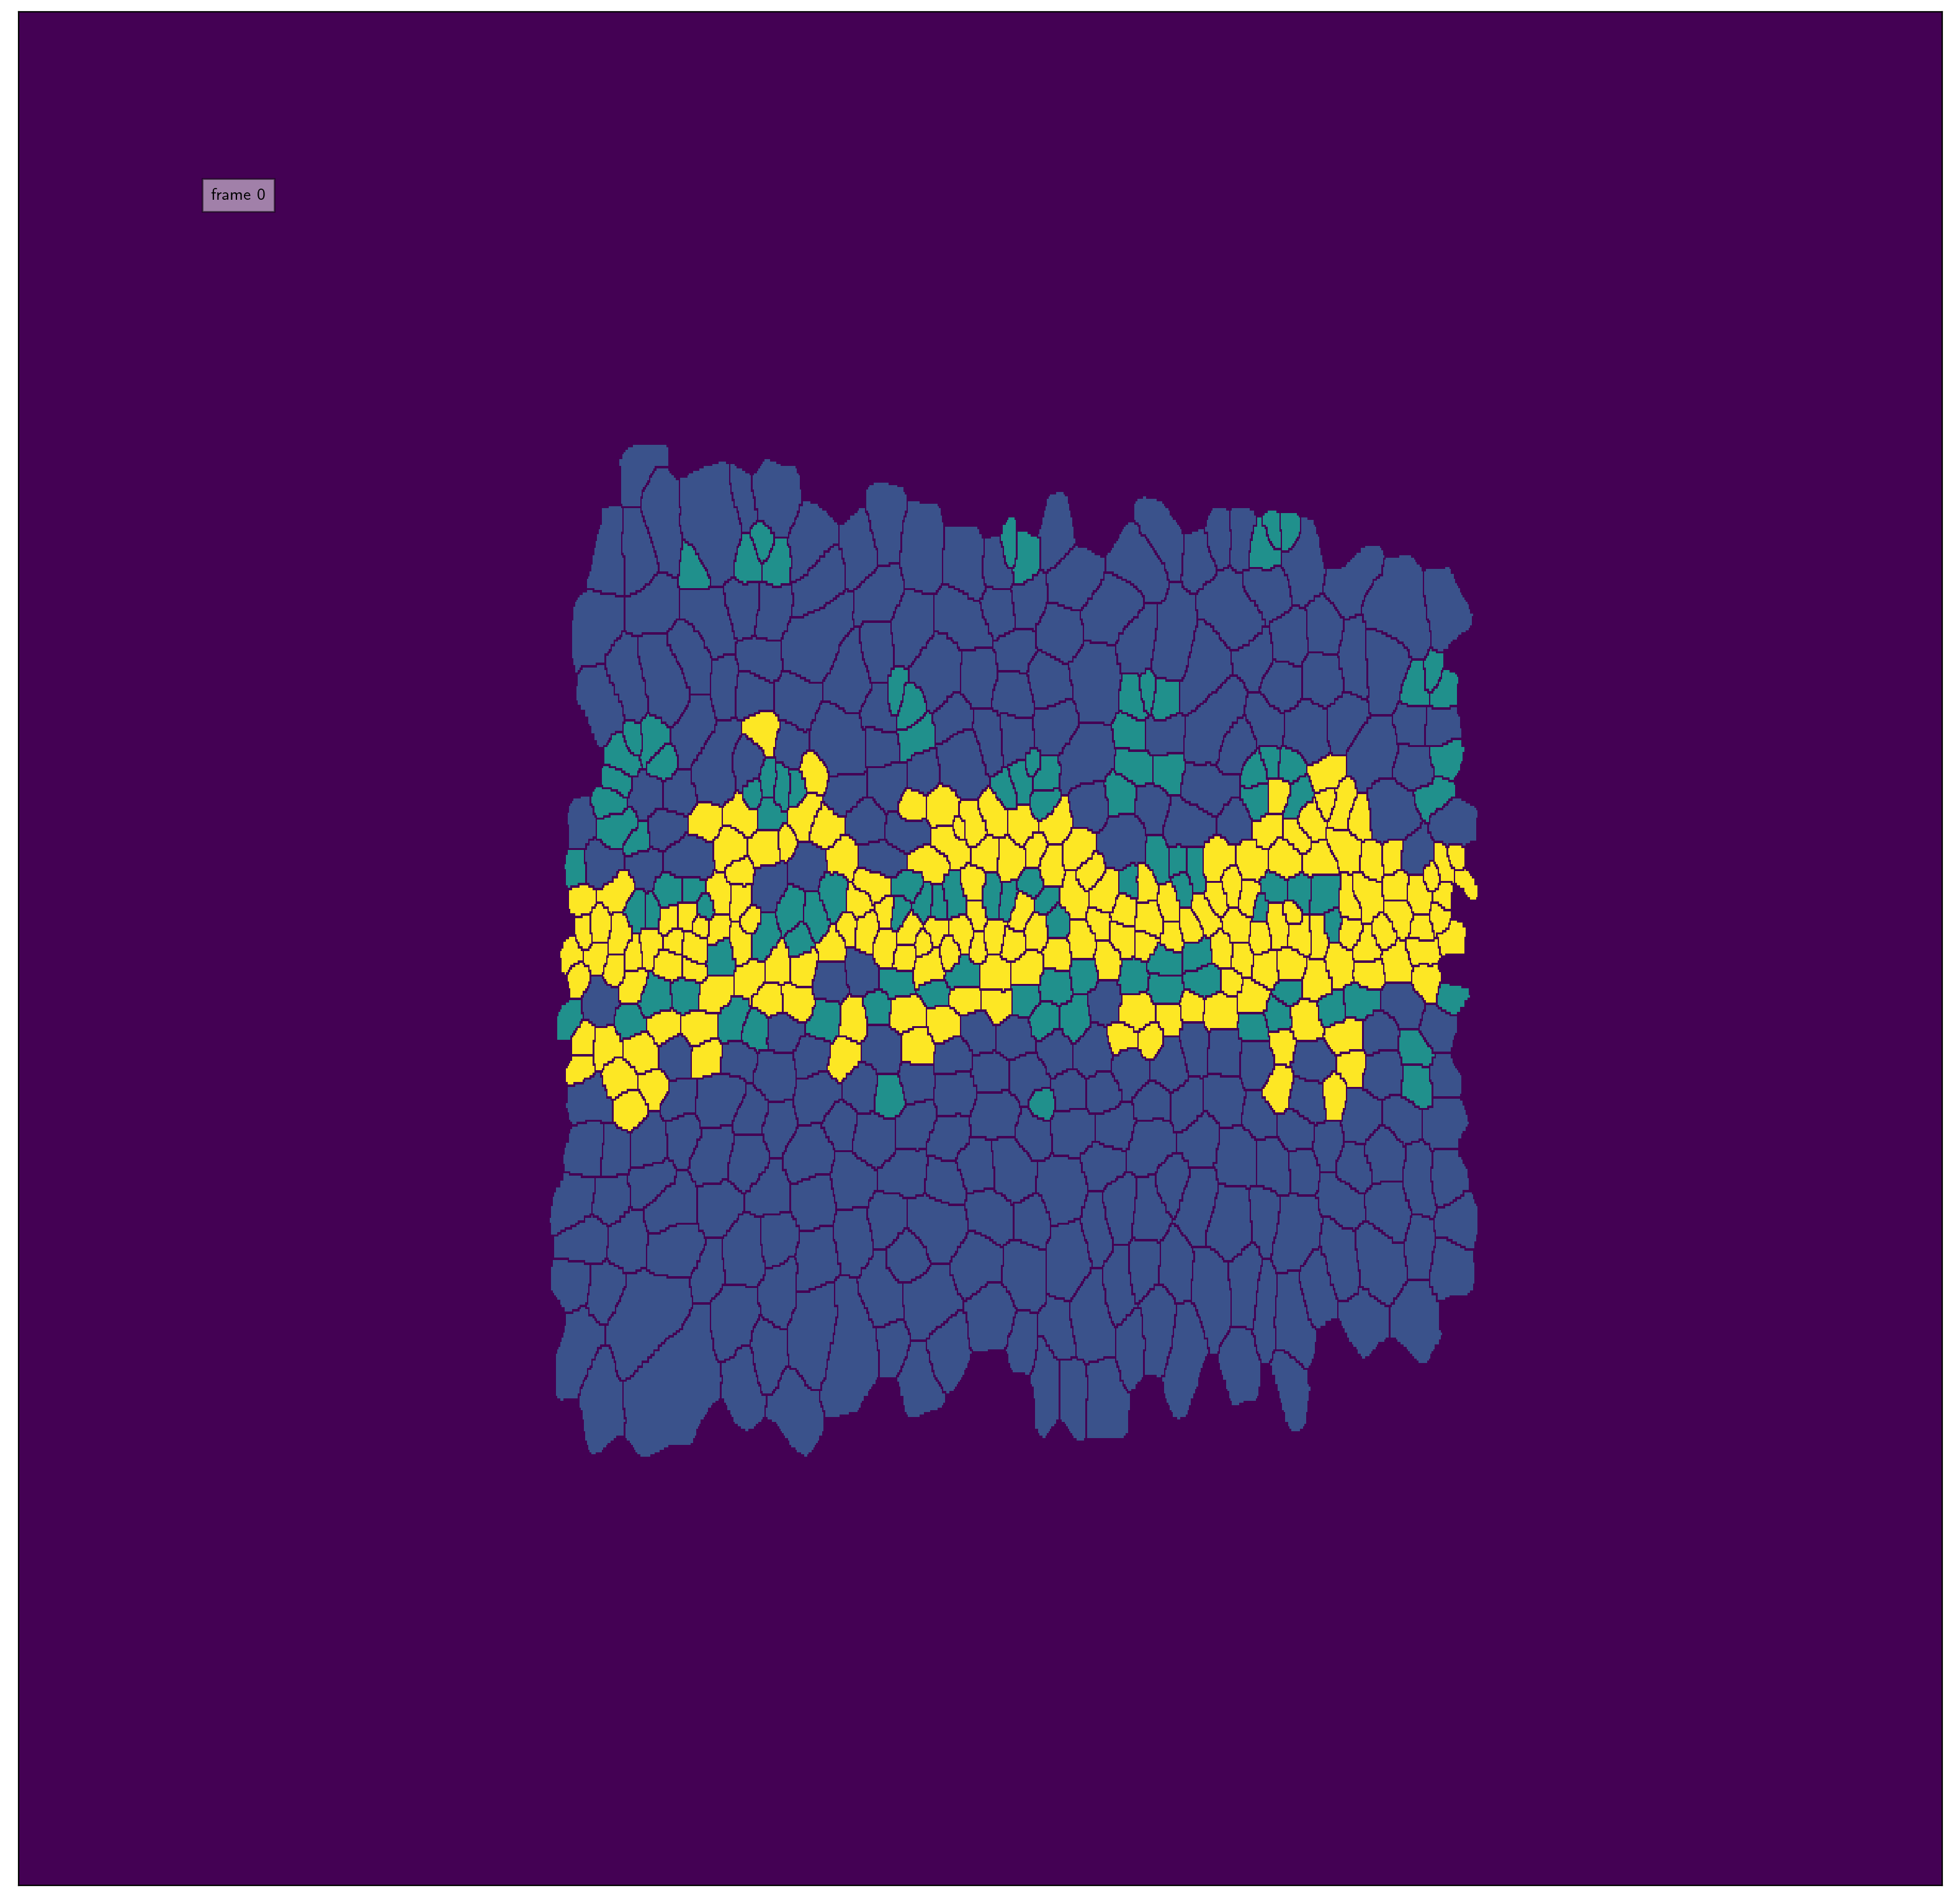

In [13]:
# make the movie:
fps = 7

# First set up the figure, the axis, and the plot element we want to animate
fig,axs = plt.subplots( figsize=(20,20), dpi=200 )
im = axs.imshow(imgs[0], interpolation='none', aspect='auto')
ttl = axs.text(0.1,0.9,"",bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},transform=axs.transAxes)
axs.set_xticks([])
axs.set_yticks([])

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(imgs[i])
    ttl.set_text('frame {0}'.format(i))
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(imgs),
                               interval = 1000 / fps, # in ms
                               )

anim.save('{0}/{1}.mp4'.format(plotdir,nm), fps=fps)#, extra_args=['-libx264']) # extra_args=['-vcodec', 'libx264'])

In [136]:
outdir

'/Users/simonfreedman//data/droso/ommatidia_data/wildtype2/obs'

In [85]:
# how to pull cell coordinates
# read the README in dat1
# i want the coordinates of the R2 cell in precluster 1 at time 5
# in matlab R8 = 1, R2 = 2, R5 = 3, R3 = 4, R4 = 5 



# preclusterID    = 0
# photoreceptorID = 6
# times           = np.arange(10)
# nrow, ncol, nt  = dat1['raw_images'].shape
# imgs            = np.zeros((len(times),nrow, ncol))
# for t in times:
#     for c_idx in range(cell_pixel_idx.shape[1]):
#         if cell_pixel_idx[t,c_idx] > -1:
#             pix                        = cell_pixels[cell_pixel_idx[t,c_idx]]
#             imgs[t,pix[:,0],pix[:,1]] += 1
#     for pr_idx in precl_idxs.reshape(-1):
#         pix = cell_pixels[cell_pixel_idx[t,pr_idx]]
#         imgs[t,pix[:,0],pix[:,1]] += 1
    

#     for prID in np.arange(5):
#         imgs[t,cell_pixel_idx_]
#         #cell_id  = int(dat1['preclusters'][preclusterID][prID]) - 1
#         #track_id = int(dat1['tracks'][cell_id,t]) - 1
#         track_id = int(dat1['tracks'][photorecep_cell_idxs[photoreceptorID,prID],t]) - 1
#         pix      =  np.array(dat1['cell_area'][t][0][track_id][0],dtype='int') - 1 
#         imgs[t,pix[:,0],pix[:,1]] = prID+1 #prID*60+1
        #imgs[t] += np.array(dat1['raw_images'][...,t],dtype='int')
#pix =  np.array(dat1['cell_area'][time][0][cellID][0],dtype='int')


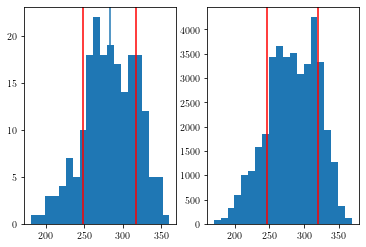

In [185]:
fig,axs=plt.subplots(1,2)
t = 5
ctrs = cell_ctr[t,mf_idxs_all[t]]
#pix = cell_pixels[cell_pixel_idx[t, mf_idxs_all_t]]
pix = np.vstack([cell_pixels[cell_pixel_idx[t, k]] for k in mf_idxs_all[t]])
axs[0].hist(ctrs[:,0],20)
axs[1].hist(pix[:,0],20)
axs[0].axvline(np.mean(ctrs[:,0]))
axs[0].axvline(np.mean(ctrs[:,0])-1*np.std(ctrs[:,0]), color='red')
axs[0].axvline(np.mean(ctrs[:,0])+1*np.std(ctrs[:,0]), color='red')
axs[1].axvline(np.mean(pix[:,0])-1*np.std(pix[:,0]), color='red')
axs[1].axvline(np.mean(pix[:,0])+1*np.std(pix[:,0]), color='red')

In [212]:
pix_pca = PCA().fit(pix)

(40837, 2)

In [215]:
pix_pca.components_
pix_mu = np.mean(pix,axis=0)
pix_mu

array([332.17609031, 363.72184539])

In [192]:
mf_pix = [np.vstack([cell_pixels[cell_pixel_idx[t, k]] for k in mf_idxs_all[t]]) for t in range(nt)]

In [196]:
pix_var = np.array(list(map(lambda x: np.var(x, axis=0),mf_pix)))

(array([22.,  3.,  7.,  7., 17.,  4.,  5.,  4.,  1.,  2.]),
 array([1123.75507959, 1815.08650673, 2506.41793388, 3197.74936103,
        3889.08078818, 4580.41221532, 5271.74364247, 5963.07506962,
        6654.40649677, 7345.73792391, 8037.06935106]),
 <a list of 10 Patch objects>)

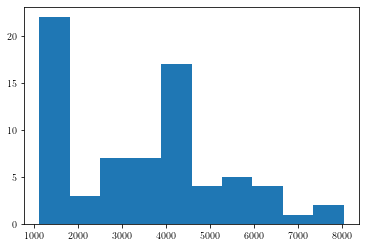

In [202]:
fig,axs=plt.subplots()
#axs.plot(range(nt),pix_var[:,1])
axs.hist(pix_var[:,0])

In [210]:
np.where(pix_var[:,0]>2000)

(array([ 3,  8, 11, 15, 16, 17, 19, 20, 23, 25, 26, 29, 31, 32, 33, 34, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55,
        56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71]),)

In [229]:
pts0,pix_mu,pts0[:,0]

(array([[332.17609031, 363.72184539],
        [336.1026848 , 413.56742549]]),
 array([332.17609031, 363.72184539]),
 array([332.17609031, 336.1026848 ]))

In [345]:
t = 0
ctrs = cell_ctr[t,mf_idxs_all[t]]
pca_ctr_coords = pix_pca.components_.dot(ctrs.T).T #np.linalg.pix_pca.components_.T
#np.where(pca_ctr_)

In [368]:
#gmm_ctrs_pca = GMM(n_components=2).fit(pca_ctr_coords) for i in range(3)]
t=0
ctrs = cell_ctr[t,mf_idxs] #mf_idxs_all[t]]
gmm_ctrs     = [GMM(n_components=i).fit(ctrs[:,[0]]) for i in [1,2]]

In [347]:
m=np.array([x.bic(ctrs) for x in gmm_ctrs])
m[0]<m[1]*1.01
#m[1]/m[0]

True

In [321]:
gmm_ctrs[2].predict(ctrs) #- gmm_ctrs_pca

IndexError: list index out of range

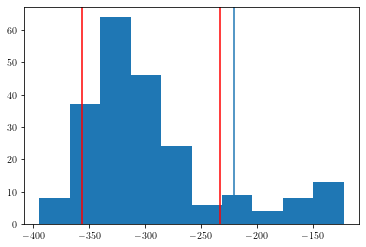

In [269]:
fig,axs=plt.subplots()
axs.hist(pca_ctr_coords[:,1])
axs.axvline(np.quantile(pca_ctr_coords[:,1],0.85))
axs.axvline(np.mean(pca_ctr_coords[:,1])+np.std(pca_ctr_coords[:,1]), color='red')
axs.axvline(np.mean(pca_ctr_coords[:,1])-np.std(pca_ctr_coords[:,1]), color='red')

In [250]:
pca_ctr_coords.shape

(205, 2)

In [255]:
np.amax(np.array([np.max(np.abs(pix_pca.components_.dot(ctrs[n])- pca_ctr_coords[n])) 
                  for n in range(pca_ctr_coords.shape[0])]))

1.1368683772161603e-13

In [243]:
pix_pca.components_.T,np.linalg.inv(pix_pca.components_.T)

(array([[ 0.07853189, -0.9969116 ],
        [ 0.9969116 ,  0.07853189]]), array([[ 0.07853189,  0.9969116 ],
        [-0.9969116 ,  0.07853189]]))

In [245]:
np.linalg.inv(pix_pca.components_.T)-pix_pca.components_

array([[-2.77555756e-17, -3.33066907e-16],
       [ 3.33066907e-16, -2.77555756e-17]])

In [350]:
mf_idxs_all[42]

array([], dtype=int64)